In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda

# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

# Install wandb
#!pip install -q wandb
import wandb

# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [2]:
# Open csv file
corpus_path = "MaCoCu-sl-en-data/Macocu-sl-en-doc-format-filtered.csv"

corpus_df = pd.read_csv(corpus_path, sep = "\t", index_col= 0)

corpus_df.head(2)

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,average_score,en_doc,sl_doc,en_length,sl_length,punct_ratio
2584979,No,sl-orig,http://15.liffe.si/?lang_chg=en,B,B,http://15.liffe.si/?lang_chg=sl,15.liffe.si,15.liffe.si,0.936808,It went out with a bang. The evening sparkled ...,Končalo se je razburljivo in z razkošjem. Veče...,574,463,0.103501
1212933,No,sl-orig,http://16.liffe.si/?lang_chg=en,B,B,http://16.liffe.si/index.php?menu_item=domov,16.liffe.si,16.liffe.si,0.900000,Some days ago the organisers of the 17th Liffe...,Pred dnevi smo se iz 59. mednarodnega filmskeg...,293,184,0.076220


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# Initialize Wandb
run = wandb.init(project="X-GENRE classifiers", entity="tajak", name="testing-trained-model")

In [6]:
# Load the trained model from Wandb
model_name = "tajak/X-GENRE classifiers/X-GENRE-classifier"
# Use the latest version of the model
model_at = run.use_artifact(model_name + ":latest")
# Download the directory
model_dir = model_at.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", "artifacts/X-GENRE-classifier:v0/")

wandb: Downloading large artifact X-GENRE-classifier:latest, 1081.88MB. 8 files... Done. 0:0:0
/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [18]:
output = model.predict(["How to create a good text classification model? First step is to prepare good data. Make sure not to skip the exploratory data analysis. Pre-process the text if necessary for the task. The next step is to perform hyperparameter search to find the optimum hyperparameters. After fine-tuning the model, you should look into the predictions and analyse the model's performance. You might want to perform the post-processing of data as well and keep only reliable predictions.", "On our site, you can find a great genre identification model which you can use for thousands of different tasks. With our model, you can fastly and reliably obtain high-quality genre predictions and explore which genres exist in your corpora. Available for free!"])

output

(['Instruction', 'Promotion'],
 array([[-1.44140625, -0.63183594, -1.14453125,  7.828125  , -1.05175781,
         -0.80957031, -0.86083984, -0.81201172, -0.71777344],
        [-0.78564453, -1.15429688, -1.26660156, -0.29980469, -1.19335938,
         -1.20410156, -1.33300781, -0.87890625,  7.7890625 ]]))

In [7]:
def predict(dataframe, file_path):
    """
    This function takes the dataframe with English documents in the en_doc column, prepared in previous notebooks, and applies the trained model on it to infer predictions. It prints the time that it took to predict to all instances. It saves the results as a new column in the dataframe and returns the dataframe.

    Args:
    - dataframe (pandas DataFrame)
    - file_path: the path to the new CSV file with predictions
    """
    # Define the label list
    labels = ["Other", "Information/Explanation", "News", "Instruction", "Opinion/Argumentation", "Forum", "Prose/Lyrical", "Legal", "Promotion"]
    
    # Split the dataframe into batches
    # Create batches of text
    from itertools import islice

    def chunk(arr_range, arr_size):
        arr_range = iter(arr_range)
        return iter(lambda: tuple(islice(arr_range, arr_size)), ())

    batches_list = list(chunk(dataframe.en_doc, 8))

    batches_list_new = []

    for i in batches_list:
        batches_list_new.append(list(i))

    print(f"The dataset is split into {len(batches_list_new)} batches of {len(batches_list_new[0])} texts.")

    # Apply softmax to the raw outputs
    def softmax(x):
    #Compute softmax values for each sets of scores in x.
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    y_pred = []
    y_distr = []
    most_probable = []
    batch_counter = 0

    print("Prediction started.")
    start_time = time.time()

    for i in batches_list_new:
        output = model.predict(i)
        current_y_pred = output[0]
        current_y_distr = output[1]
        current_y_distr_softmax = []
        current_y_distr_most_probable = []
        for i in current_y_distr:
            distr = softmax(i)
            distr_dict = {labels[i]: round(distr[i],4) for i in range(len(labels))}
            current_y_distr_softmax.append(distr_dict)
            # Also add the information for the softmax of the most probable category ("certainty")
            distr_sorted = np.sort(distr)
            current_y_distr_most_probable.append(distr_sorted[-1])

        for i in current_y_pred:
            y_pred.append(i)
        
        for i in current_y_distr_softmax:
            y_distr.append(i)
        
        for i in current_y_distr_most_probable:
            most_probable.append(i)

        batch_counter += 1
        print(f"Batch {batch_counter} predicted.")
        
        json_backup = [batch_counter,y_pred, y_distr, most_probable]

        # Save y_pred and y_distr just in case
        with open("batch-backup-predictions.json","w") as backup:
            json.dump(json_backup, backup)

    prediction_time = round((time.time() - start_time)/60,2)

    print(f"Prediction completed. It took {prediction_time} minutes for {dataframe.shape[0]} instances - {prediction_time/dataframe.shape[0]} minutes per one instance.")
    
    dataframe["X-GENRE"] = y_pred
    dataframe["label_distribution"] = y_distr
    dataframe["chosen_category_distr"] = most_probable

    # Save the new dataframe which contains the y_pred values as well
    dataframe.to_csv(f"{file_path}", sep="\t")

    return dataframe

In [8]:
# Try the code on a sample of the corpus
sample_corpus = corpus_df.sample(n = 20)

sample_corpus.shape

(20, 14)

In [9]:
sample_predicted = predict(sample_corpus, "sample-corpus-filtered-predicted-test.csv") 

The dataset is split into 3 batches of 8 texts.
Prediction started.
Batch 1 predicted.
Batch 2 predicted.
Batch 3 predicted.
Prediction completed. It took 0.09 minutes for 20 instances - 0.0045 minutes per one instance.


Prediction took 12 seconds per instance - it would take 350 hours (14 days) to predict everything. Using batches speeds up prediction a lot - by predicting on batches of 8 texts (if the batch is larger than 8, the prediction freezes), prediction takes 0.16 seconds per instances - prediction for the whole dataset would take 4.4 hours.

In [10]:
sample_predicted.head(3)

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,average_score,en_doc,sl_doc,en_length,sl_length,punct_ratio,X-GENRE,label_distribution,chosen_category_distr
236120,No,en-orig,https://www.avtomobilski-nadstreski.si/eng/cat...,UNK,B,https://www.avtomobilski-nadstreski.si/katalog...,avtomobilski-nadstreski.si,avtomobilski-nadstreski.si,0.954375,Catalogs/Technical data For easy and safe prot...,Katalogi / tehnični podatki Za enostavno in va...,106,99,0.071429,Information/Explanation,"{'Other': 0.0005, 'Information/Explanation': 0...",0.947393
2233823,No,sl-orig,https://www.europarl.europa.eu/news/en/headlin...,UNK,B,https://www.europarl.europa.eu/news/sl/headlin...,europarl.europa.eu,europarl.europa.eu,0.923364,Parliament adopted a resolution condemning the...,"Evropski poslanci so sprejeli dva sklada, ki b...",246,332,0.065693,News,"{'Other': 0.0001, 'Information/Explanation': 0...",0.998937
61600,No,sl-orig,https://www.avtokampi.si/campsites/camping-marina,B,MIX,https://www.avtokampi.si/kampi/kamp-marina,avtokampi.si,avtokampi.si,0.897265,*The price of the pitch depends on the exact l...,*Cena parcele je odvisna od točne lokacije in ...,573,511,0.087558,Instruction,"{'Other': 0.0045, 'Information/Explanation': 0...",0.931755


Then, I copied the code to a python script which is to be ran to predict on the entire dataset. The code was ran on the terminal by writing the following:
```nohup python predict_genres.py```
To set up the same environment in the Visual Studio Code which is used in the notebook, follow instructions on this link: https://fabianlee.org/2021/12/23/vscode-add-a-directory-to-the-terminal-path/. Add to the JSON setting the following:
```
    "terminal.integrated.env.linux":{
        "PATH":"/home/tajak/anaconda3/bin:${env:PATH}"
    }
```

## Manual analysis of predicted sample (first round)

In [20]:
sample_predicted

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,average_score,en_doc,sl_doc,en_length,sl_length,punct_ratio,X-GENRE,label_distribution
119268,No,sl-orig,http://dk.mors.si/IzpisGradiva.php?id=633&amp;...,B,MIX,http://dk.mors.si/Iskanje.php?type=napredno&am...,dk.mors.si,dk.mors.si,0.953400,"On 6 April 1941, the German invader, together ...",Abstract: 6. aprila 1941 je nemški okupator s ...,194,183,0.102222,Information/Explanation,"{'Other': 0.0005372374504373195, 'Information/..."
922930,No,en-orig,https://www.olimpus-shop.si/review/product/lis...,A,MIX,https://www.olimpus-shop.si/atx-klop-nastavlji...,olimpus-shop.si,olimpus-shop.si,0.885111,Back 15-fold adjustable in inclination of -10 ...,Naslonjalo za hrbet je 15-kratno nastavljivo z...,137,104,0.040816,Promotion,"{'Other': 0.00013954373553679787, 'Information..."
1347621,No,sl-orig,http://www.eu-skladi.si/en/in-focus/news/slove...,UNK,B,https://eu-skladi.si/sl/aktualno/novice/sloven...,eu-skladi.si,eu-skladi.si,0.847667,"Ljubljana, 11 June 2021 – Slovenia officially ...","Ljubljana, 11. junij 2021 - Slovenija je Načrt...",97,82,0.048077,Legal,"{'Other': 0.0009385541834495491, 'Information/..."
1907378,No,sl-orig,https://eur-lex.europa.eu/legal-content/EN/TXT...,B,B,https://eur-lex.europa.eu/legal-content/SL/ALL...,eur-lex.europa.eu,eur-lex.europa.eu,0.830500,Opinion of the European Economic and Social Co...,Evropska agenda za sodelovalno gospodarstvo So...,194,7281,0.084821,Legal,"{'Other': 0.001932523122196174, 'Information/E..."
1743983,No,sl-orig,http://www.worldofart.org/current/year16-2016-...,B,B,http://www.worldofart.org/aktualno/sestnajsto-...,worldofart.org,worldofart.org,0.958095,"With the exhibition re-, World of art, School ...","Svet umetnosti, šola za kuratorske prakse in k...",776,598,0.080226,Information/Explanation,"{'Other': 0.0002928942216638257, 'Information/..."
2458985,No,sl-orig,http://visitcerkno.si/en/the-village-of-zakriz...,A,A,http://visitcerkno.si/vas-zakriz-tako-velik-kr...,visitcerkno.si,visitcerkno.si,0.927066,The village of Zakriž was built on a landslide...,"Vas Zakriž je zrasla na veliki plazovini, ki s...",1408,1151,0.095443,Information/Explanation,"{'Other': 0.00010515274744223405, 'Information..."
288497,No,sl-orig,http://arhiv.kulturnidom-ng.si/eng/glasbenipro...,B,B,http://arhiv.kulturnidom-ng.si/glasbeniprogram...,arhiv.kulturnidom-ng.si,arhiv.kulturnidom-ng.si,0.809632,The Slovene competitor with the best assessmen...,Igrati je treba izključno iz originalnih parti...,501,593,0.070568,News,"{'Other': 0.0019496682888039793, 'Information/..."
1484495,No,sl-orig,https://www.lifelynx.eu/risinja-teja-ima-mladica/,UNK,MIX,https://www.lifelynx.eu/risinja-teja-ima-mladi...,lifelynx.eu,lifelynx.eu,0.859600,We have already reported the interesting meeti...,Poročali smo že o zanimivem druženju risov Tej...,272,224,0.076433,Information/Explanation,"{'Other': 0.00010457956105937027, 'Information..."
2684258,Yes,sl-orig,http://www.e-arhiv.org/diva/index.php?opt=auth...,UNK,MIX,http://www.e-arhiv.org/diva/MihaSubic,e-arhiv.org,e-arhiv.org,0.822286,"Miha Šubic born in 1988 (Maribor, Slovenia). C...","Miha Šubic (Maribor, 1988) je soustanovitelj f...",145,87,0.127551,Information/Explanation,"{'Other': 0.00011101183437423402, 'Information..."
2286533,Yes,sl-orig,https://www.kinodvor.org/en/film/elena-in-mozje/,B,B,https://www.kinodvor.org/film/elena-in-mozje/,kinodvor.org,kinodvor.org,0.893680,She successively becomes the muse and inspirat...,"Muza in navdih je zdaj skladatelju, zdaj indus...",475,417,0.085145,Opinion/Argumentation,"{'Other': 0.00030559324094532245, 'Information..."


In [125]:
sample_predicted.shape

(100, 18)

In [20]:
# Analyze label distribution
sample_predicted["X-GENRE"].value_counts(normalize=True)

Information/Explanation    0.34
Promotion                  0.28
Instruction                0.16
Legal                      0.08
Opinion/Argumentation      0.06
News                       0.06
Other                      0.02
Name: X-GENRE, dtype: float64

In [21]:
# Analyze the softmax values
sample_predicted["label_distribution"].describe()

count    50.000000
mean      0.991974
std       0.021747
min       0.888406
25%       0.997213
50%       0.998835
75%       0.998986
max       0.999102
Name: label_distribution, dtype: float64

Most values are very high.

In [3]:
# Open the file with predictions which was manually analyses

analysed_df = pd.read_csv("sample-corpus-predicted.csv", sep="\t", index_col = 0)

analysed_df.head(3)

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,same_domains,different_domains,average_score,en_doc,sl_doc,en_length,sl_length,output,X-GENRE,label_distribution,analysis,comments
1887229,Yes,sl-orig,https://www.europarl.europa.eu/doceo/document/...,B,B,https://www.europarl.europa.eu/doceo/document/...,europarl.europa.eu,europarl.europa.eu,yes,europarl.europa.eu europarl.europa.eu,0.838333,Implementation of EU requirements for exchange...,Varnostne razmere v Burkina Fasu Izjava podpre...,101,119,"(['News'], array([[-1.33398438, 2.00195312, ...",News,0.991544,Non-textual,"not suitable: samo naštevanje naslovov, mi bi ..."
799225,No,sl-orig,https://www.grafolit.si/en/about_us.html,UNK,B,https://www.grafolit.si/onas.html,grafolit.si,grafolit.si,yes,grafolit.si grafolit.si,0.926091,DEVELOPMENT AND SHORT HISTORY The company was ...,RAZVOJ IN KRATKA ZGODOVINA Podjetje je ustanov...,463,223,"(['Information/Explanation'], array([[-0.68066...",Information/Explanation,0.999070,Information/Explanation,NaN
1001538,No,sl-orig,https://oblacila.si/nike-nike-advance-polo-shi...,A,MIX,https://oblacila.si/craft-craft-fuseknit-light...,oblacila.si,oblacila.si,yes,oblacila.si oblacila.si,0.814500,Smooth T-shirt with a round neckline. Smooth T...,"Izdelana je iz 100% bombaža, ki zelo dobro dih...",188,63,"(['Promotion'], array([[-0.60498047, -0.895507...",Promotion,0.998907,Promotion,"besedilo v angleščini se ponavlja, mogoče neka..."


In [134]:
# Analyze distribution of manually assigned labels
analysed_df.analysis.value_counts()

Promotion                  36
Information/Explanation    31
Non-textual                13
Instruction                 9
Opinion/Argumentation       4
News                        3
Legal                       3
Other                       1
Name: analysis, dtype: int64

In [5]:
# Analyze the characteristics of non-textual texts that were not removed with additional processing
remaining_non_textual = [150635, 2754062, 84675]


for i in remaining_non_textual:
	print(analysed_df.loc[i].en_doc)
	print(analysed_df.loc[i].label_distribution)


Dejan Habicht - Zvočni film / Sound Movie (00:05:22) Subtitle: 12 dolgočasnih pesmi Production: Center in Galerija P74, 2007 The sound of an airplane over a forest. Dejan Habicht - Nevarni vzorci Subtitle: 12 dolgočasnih pesmi Production: Center in Galerija P74, 2006 Dangerous Patterns is an electronic book, which can be printed at home (557KB). Dejan Habicht - die Heißeste Nummer Subtitle: 12 dolgočasnih pesmi Production: Center in Galerija P74, 2004/06 die Heißeste Nummer / The Hottest Number is an e-book that one can print at home. Saša Spačal - 7K: new life form (00:10:13) Production: Saša Spačal, Muzej sodobne umetnosti Metelkova - MSUM+, 2016 The video conceptually reflects on 7K: new life form, an artwork by Saša Spačal.
0.9986470725751748
Instructions for use of QR Code for FOTO LADO d.o.o. Click here for further information. Instructions for use of QR Code for STROPNIK RADO s.p. Instructions for use of QR Code for STROPNIK RADO s.p. Instructions for use of QR Code for PETER KL

In [135]:
# Discard texts that are in reality non-textual from the analysis
analysed_cleaned = analysed_df[analysed_df["analysis"]!= "Non-textual"]
analysed_cleaned.shape

(87, 20)

In [143]:
# Define labels that are present in the sample
print(analysed_cleaned.analysis.unique())
print(analysed_cleaned["X-GENRE"].unique())


LABELS = ['Information/Explanation', 'Promotion', 'Opinion/Argumentation', 'News', 'Instruction', 'Legal', 'Forum', 'Other']

['Information/Explanation' 'Promotion' 'Opinion/Argumentation' 'News'
 'Instruction' 'Legal' 'Other']
['Information/Explanation' 'Promotion' 'Opinion/Argumentation' 'News'
 'Instruction' 'Legal' 'Forum' 'Other']


Macro f1: 0.663, Micro f1: 0.908


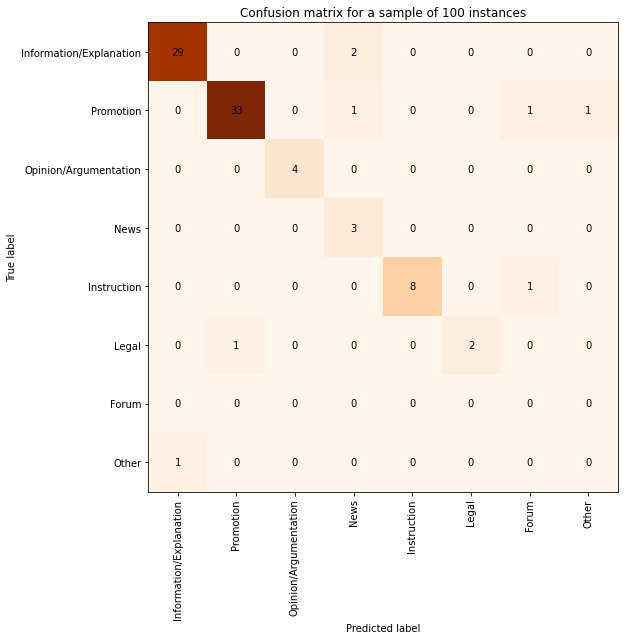

                         precision    recall  f1-score   support

Information/Explanation       0.97      0.94      0.95        31
              Promotion       0.97      0.92      0.94        36
  Opinion/Argumentation       1.00      1.00      1.00         4
                   News       0.50      1.00      0.67         3
            Instruction       1.00      0.89      0.94         9
                  Legal       1.00      0.67      0.80         3
                  Forum       0.00      0.00      0.00         0
                  Other       0.00      0.00      0.00         1

               accuracy                           0.91        87
              macro avg       0.68      0.68      0.66        87
           weighted avg       0.95      0.91      0.92        87



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

In [147]:
# Analyse results
y_true = analysed_cleaned["analysis"].to_list()
y_pred = analysed_cleaned["X-GENRE"].to_list()

# Calculate the scores
macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")

print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

# Plot the confusion matrix:
cm = confusion_matrix(y_true, y_pred, labels=LABELS)
plt.figure(figsize=(9, 9))
plt.imshow(cm, cmap="Oranges")
for (i, j), z in np.ndenumerate(cm):
	plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
classNames = LABELS
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=90)
plt.yticks(tick_marks, classNames)
plt.title(f"Confusion matrix for a sample of 100 instances")

plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
# Save the confusion matrix
fig1.savefig(f"Confusion-matrix-predicted-sample.png",dpi=100)

# Print classification report
print(classification_report(y_true, y_pred, labels = LABELS))